# Notebook MVP da Sprint 4 (Engenharia de Software) - Flávio Portugal

Esse notebook tem como objetivo classificar se uma água é segura para consumo humano, onde 1 significa Potável e 0 significa Não potável.

##Dataset utilizado foi o Water Potability Dataset:
https://www.kaggle.com/datasets/devanshibavaria/water-potability-dataset-with-10-parameteres


##Colunas do Dataset

1. **ph**:
O pH é um parâmetro importante na avaliação do equilíbrio ácido-base da água. -

1. **Hardness**:
A dureza é a capacidade da água de precipitar sabão causada pelo Cálcio e pelo Magnésio.

1. **Solids**:
O Total dissolved solids (TDS) indica se a água é altamente mineralizada. A água tem a capacidade de dissolver uma ampla gama de minerais ou sais inorgânicos e alguns orgânicos.

1. **Chloramines**:
O cloro e a cloramina são os principais desinfetantes utilizados nos sistemas públicos de água.

1. **Sulfate**:
Sulfatos são substâncias naturais encontradas em minerais, solo e rochas.

1. **Conductivity**:
A água pura não é um bom condutor de corrente elétrica, mas sim um bom isolante. O aumento da condutividade elétrica da água, indica a quantidade de sólidos dissolvidos na água.

1. **Organic_carbon**:
O carbono orgânico total (TOC) é uma medida da quantidade total de carbono em compostos orgânicos em água pura.

1. **Trihalomethanes**:
THMs são produtos químicos que podem ser encontrados na água tratada com cloro.

1. **Turbidity**:
A turbidez é uma medida das propriedades de emissão de luz da água, usada para indicar a qualidade da descarga de resíduos em relação à matéria coloidal.

1. **Potability**:
Indica se a água é segura para consumo humano onde 1 significa Potável e 0 significa Não potável.

A coluna **Potability** é o rótulo categórico (*classe*)

## Imports necessários

In [1]:
# configuração para não exibir os warnings
import warnings
warnings.filterwarnings("ignore")

# Imports necessários
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from pickle import dump

## Carga do Dataset

In [2]:
# Informa a URL de importação do dataset
url = "https://raw.githubusercontent.com/flavioportugal20/mvp-sprint4-puc/main/data/dataset_water_potability.csv"

# Lê o arquivo
dataset = pd.read_csv(url, delimiter=',')

# Mostra as primeiras linhas do dataset
dataset.head()



,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,6.548021,278.585105,25508.386949,6.749378,366.871502,497.321753,16.563167,79.323678,3.611860,1
1,13.175402,47.432000,19237.949676,8.907020,375.147315,500.245952,12.083896,NaN,4.106924,1
2,6.618011,233.661636,19598.860740,4.701049,432.556385,401.669791,11.766146,73.191921,4.437696,1
3,7.788055,212.691457,29879.060146,6.998962,360.668259,359.569082,14.828743,83.856336,3.368757,1
4,5.191834,211.094185,14866.103863,7.238691,323.109285,388.716580,17.780000,83.505406,3.859801,1


## Tratamento dos dados do dataset



In [15]:
# Detecta valores ausentes
dataset.isnull().sum()

ph                 446
Hardness             0
Solids               0
Chloramines          0
Sulfate            717
Conductivity         0
Organic_carbon       0
Trihalomethanes    151
Turbidity            0
Potability           0
dtype: int64

In [3]:
# Substitui NaNs pela média das colunas especificadas

dataset['ph'].fillna(value=dataset['ph'].median(),inplace=True)
dataset['Sulfate'].fillna(value=dataset['Sulfate'].median(),inplace=True)
dataset['Trihalomethanes'].fillna(value=dataset['Trihalomethanes'].median(),inplace=True)
#dataset = dataset.dropna()
dataset.isnull().sum()

ph                 0
Hardness           0
Solids             0
Chloramines        0
Sulfate            0
Conductivity       0
Organic_carbon     0
Trihalomethanes    0
Turbidity          0
Potability         0
dtype: int64

In [4]:
#Renomei as colunas
dataset.columns = ['ph',
                    'hardness',
                    'solids',
                    'chloramines',
                    'sulfate',
                    'conductivity',
                    'organic_carbon',
                    'trihalomethanes',
                    'turbidity',
                    'potability']


# Mostra as primeiras linhas do dataset depois do tratamento
dataset.head()

,ph,hardness,solids,chloramines,sulfate,conductivity,organic_carbon,trihalomethanes,turbidity,potability
0,6.548021,278.585105,25508.386949,6.749378,366.871502,497.321753,16.563167,79.323678,3.611860,1
1,13.175402,47.432000,19237.949676,8.907020,375.147315,500.245952,12.083896,66.668576,4.106924,1
2,6.618011,233.661636,19598.860740,4.701049,432.556385,401.669791,11.766146,73.191921,4.437696,1
3,7.788055,212.691457,29879.060146,6.998962,360.668259,359.569082,14.828743,83.856336,3.368757,1
4,5.191834,211.094185,14866.103863,7.238691,323.109285,388.716580,17.780000,83.505406,3.859801,1


In [5]:
# Verifica se existem apenas zeros e uns na coluna Potability
dataset['potability'].value_counts()

potability
0    1748
1    1266
Name: count, dtype: int64

## Separação em conjunto de treino e conjunto de teste com holdout

In [6]:
test_size = 0.20 # tamanho do conjunto de teste
seed = 7 # semente aleatória

# Separação em conjuntos de treino e teste
array = dataset.values
X = array[:,0:9]
y = array[:,9]

# separação do conjunto de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y,
    test_size=test_size, shuffle=True, random_state=seed, stratify=y) # holdout com estratificação

# Parâmetros e partições da validação cruzada
scoring = 'accuracy'
num_particoes = 10
kfold = StratifiedKFold(n_splits=num_particoes, shuffle=True, random_state=seed) # validação cruzada com estratificação

## Modelagem e Inferência

### Criação e avaliação de modelos: linha base

KNN: 0.529661 (0.026083)
CART: 0.583996 (0.024726)
NB: 0.609693 (0.024128)
SVM: 0.579428 (0.001881)
GradientBoosting: 0.629608 (0.020351)
AdaBoost: 0.584399 (0.025589)
Bagging: 0.617589 (0.029174)
DecisionTree: 0.588142 (0.026308)
ExtraTree: 0.562426 (0.023780)
RandomForest: 0.652846 (0.021233)
LogisticRegression: 0.579428 (0.002642)


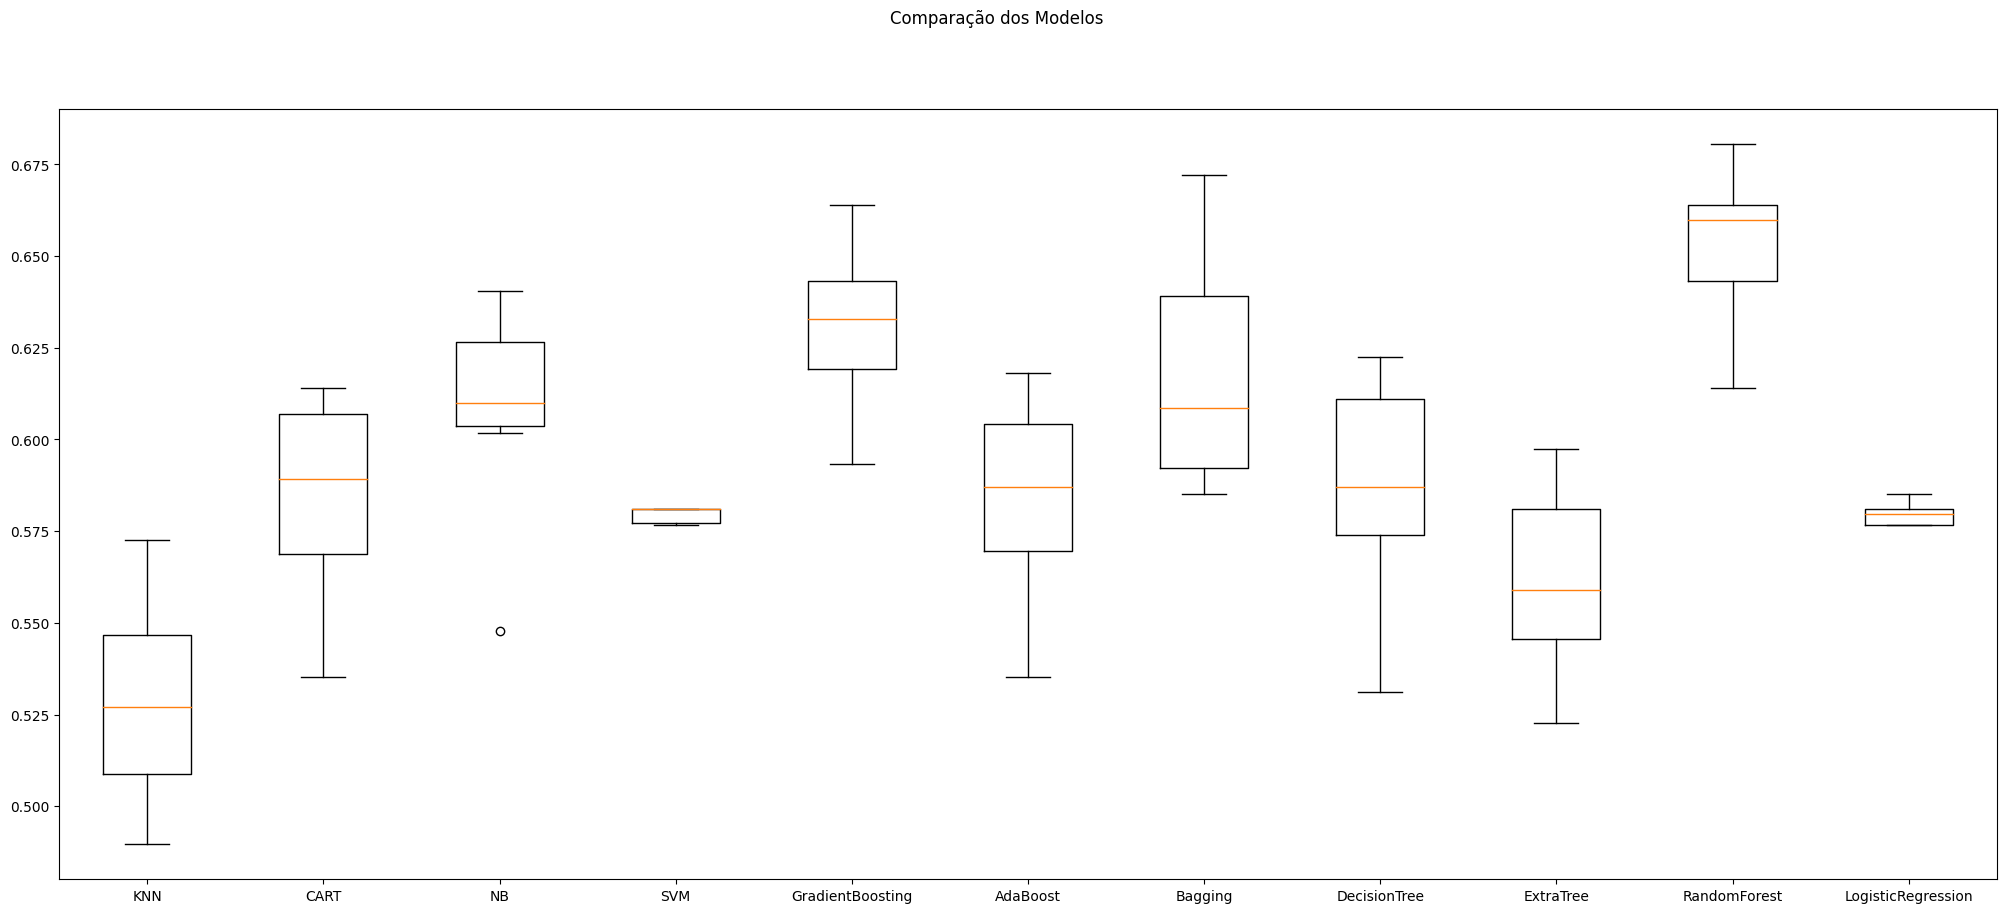

In [21]:
np.random.seed(7) # definindo uma semente global

# Lista que armazenará os modelos
models = []

# Criando os modelos e adicionando-os na lista de modelos
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))
models.append(('GradientBoosting', GradientBoostingClassifier()))
models.append(('AdaBoost', AdaBoostClassifier()))
models.append(('Bagging', BaggingClassifier()))
models.append(('DecisionTree', DecisionTreeClassifier()))
models.append(('ExtraTree', ExtraTreeClassifier()))
models.append(('RandomForest', RandomForestClassifier()))
models.append(('LogisticRegression', LogisticRegression()))

# Listas para armazenar os resultados
results = []
names = []

# Avaliação dos modelos
for name, model in models:
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(25,10))
fig.suptitle('Comparação dos Modelos')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

### Criação e avaliação de modelos: dados padronizados e normalizados

KNN-orig: 0.530 (0.026)
CART-orig: 0.584 (0.025)
NB-orig: 0.610 (0.024)
SVM-orig: 0.579 (0.002)
GradientBoosting-orig: 0.630 (0.020)
AdaBoost-orig: 0.584 (0.026)
Bagging-orig: 0.618 (0.029)
DecisionTree-orig: 0.588 (0.026)
ExtraTree-orig: 0.562 (0.024)
RandomForest-orig: 0.653 (0.021)
LogisticRegression-orig: 0.579 (0.003)
KNN-padr: 0.611 (0.026)
CART-padr: 0.574 (0.035)
NB-padr: 0.607 (0.024)
SVM-padr: 0.662 (0.014)
GradientBoosting-padr: 0.632 (0.021)
AdaBoost-padr: 0.584 (0.026)
Bagging-padr: 0.633 (0.024)
DecisionTree-padr: 0.577 (0.031)
ExtraTree-padr: 0.551 (0.031)
RandomForest-padr: 0.643 (0.019)
LogisticRegression-padr: 0.583 (0.010)
KNN-norm: 0.603 (0.024)
CART-norm: 0.583 (0.027)
NB-norm: 0.607 (0.024)
SVM-norm: 0.651 (0.015)
GradientBoosting-norm: 0.629 (0.022)
AdaBoost-norm: 0.584 (0.026)
Bagging-norm: 0.627 (0.029)
DecisionTree-norm: 0.586 (0.030)
ExtraTree-norm: 0.550 (0.034)
RandomForest-norm: 0.645 (0.017)
LogisticRegression-norm: 0.583 (0.007)


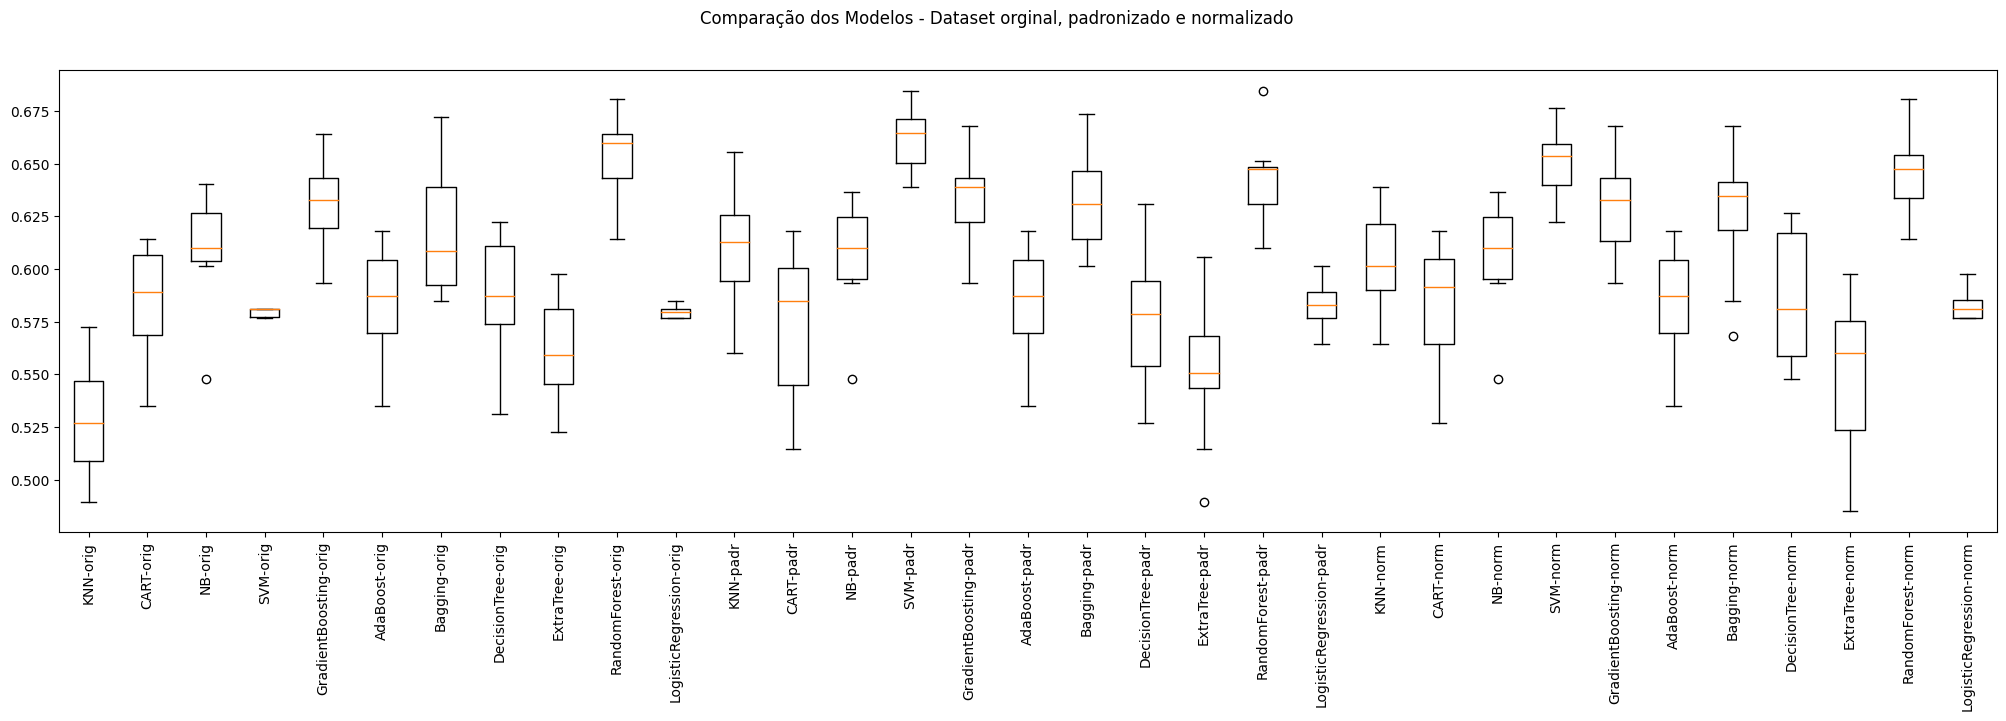

In [22]:
np.random.seed(7) # definindo uma semente global para este bloco

# Listas para armazenar os armazenar os pipelines e os resultados para todas as visões do dataset
pipelines = []
results = []
names = []

# Criando os elementos do pipeline

# Algoritmos que serão utilizados

knn = ('KNN', KNeighborsClassifier())
cart = ('CART', DecisionTreeClassifier())
naive_bayes = ('NB', GaussianNB())
svm = ('SVM', SVC())
gb = ('GradientBoosting', GradientBoostingClassifier())
ab = ('AdaBoost', AdaBoostClassifier())
bagging = ('Bagging', BaggingClassifier())
dt = ('DecisionTree', DecisionTreeClassifier())
et = ('ExtraTree', ExtraTreeClassifier())
rf = ('RandomForest', RandomForestClassifier())
pl = ('LogisticRegression', LogisticRegression())

# Transformações que serão utilizadas
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())

# Montando os pipelines

# Dataset original
pipelines.append(('KNN-orig', Pipeline([knn])))
pipelines.append(('CART-orig', Pipeline([cart])))
pipelines.append(('NB-orig', Pipeline([naive_bayes])))
pipelines.append(('SVM-orig', Pipeline([svm])))
pipelines.append(('GradientBoosting-orig', Pipeline([gb])))
pipelines.append(('AdaBoost-orig', Pipeline([ab])))
pipelines.append(('Bagging-orig', Pipeline([bagging])))
pipelines.append(('DecisionTree-orig', Pipeline([dt])))
pipelines.append(('ExtraTree-orig', Pipeline([et])))
pipelines.append(('RandomForest-orig', Pipeline([rf])))
pipelines.append(('LogisticRegression-orig', Pipeline([pl])))

# Dataset Padronizado
pipelines.append(('KNN-padr', Pipeline([standard_scaler, knn])))
pipelines.append(('CART-padr', Pipeline([standard_scaler, cart])))
pipelines.append(('NB-padr', Pipeline([standard_scaler, naive_bayes])))
pipelines.append(('SVM-padr', Pipeline([standard_scaler, svm])))
pipelines.append(('GradientBoosting-padr', Pipeline([standard_scaler, gb])))
pipelines.append(('AdaBoost-padr', Pipeline([standard_scaler, ab])))
pipelines.append(('Bagging-padr', Pipeline([standard_scaler, bagging])))
pipelines.append(('DecisionTree-padr', Pipeline([standard_scaler, dt])))
pipelines.append(('ExtraTree-padr', Pipeline([standard_scaler, et])))
pipelines.append(('RandomForest-padr', Pipeline([standard_scaler, rf])))
pipelines.append(('LogisticRegression-padr', Pipeline([standard_scaler, pl])))

# Dataset Normalizado
pipelines.append(('KNN-norm', Pipeline([min_max_scaler, knn])))
pipelines.append(('CART-norm', Pipeline([min_max_scaler, cart])))
pipelines.append(('NB-norm', Pipeline([min_max_scaler, naive_bayes])))
pipelines.append(('SVM-norm', Pipeline([min_max_scaler, svm])))
pipelines.append(('GradientBoosting-norm', Pipeline([min_max_scaler, gb])))
pipelines.append(('AdaBoost-norm', Pipeline([min_max_scaler, ab])))
pipelines.append(('Bagging-norm', Pipeline([min_max_scaler, bagging])))
pipelines.append(('DecisionTree-norm', Pipeline([min_max_scaler, dt])))
pipelines.append(('ExtraTree-norm', Pipeline([min_max_scaler, et])))
pipelines.append(('RandomForest-norm', Pipeline([min_max_scaler, rf])))
pipelines.append(('LogisticRegression-norm', Pipeline([min_max_scaler, pl])))

# Executando os pipelines
for name, model in pipelines:
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %.3f (%.3f)" % (name, cv_results.mean(), cv_results.std()) # formatando para 3 casas decimais
    print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(25,6))
fig.suptitle('Comparação dos Modelos - Dataset orginal, padronizado e normalizado')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names, rotation=90)
plt.show()

### Otimização dos hiperparâmetros

In [23]:
# Tuning do SVM

np.random.seed(7) # definindo uma semente global para este bloco
pipelines = []

svm = ('SVM', SVC())
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())

pipelines.append(('svm-orig', Pipeline(steps=[svm])))
pipelines.append(('svm-padr', Pipeline(steps=[standard_scaler, svm])))
pipelines.append(('svm-norm', Pipeline(steps=[min_max_scaler, svm])))
param_grid = {'SVM__C': [0.1, 1, 10, 100, 1000],
              'SVM__gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'SVM__kernel': ['rbf']}

# Prepara e executa o GridSearchCV
for name, model in pipelines:
    grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
    grid.fit(X_train, y_train)
    # imprime a melhor configuração
    print("Sem tratamento de missings: %s - Melhor: %f usando %s" % (name, grid.best_score_, grid.best_params_))

Sem tratamento de missings: svm-orig - Melhor: 0.579843 usando {'SVM__C': 0.1, 'SVM__gamma': 1, 'SVM__kernel': 'rbf'}
Sem tratamento de missings: svm-padr - Melhor: 0.661133 usando {'SVM__C': 1, 'SVM__gamma': 0.1, 'SVM__kernel': 'rbf'}
Sem tratamento de missings: svm-norm - Melhor: 0.658655 usando {'SVM__C': 100, 'SVM__gamma': 1, 'SVM__kernel': 'rbf'}


## Finalização do Modelo

In [7]:
# Avaliação do modelo com o conjunto de testes

# Preparação do modelo
scaler = StandardScaler().fit(X_train) # ajuste do scaler com o conjunto de treino
rescaledX = scaler.transform(X_train) # aplicação da padronização no conjunto de treino
model = SVC(C=1, gamma=0.1, kernel='rbf')
model.fit(rescaledX, y_train)

# Estimativa da acurácia no conjunto de teste
rescaledTestX = scaler.transform(X_test) # aplicação da padronização no conjunto de teste
predictions = model.predict(rescaledTestX)
print(accuracy_score(y_test, predictions))

0.6683250414593698


In [8]:
# Preparação do modelo com TODO o dataset
scaler = StandardScaler().fit(X) # ajuste do scaler com TODO o dataset
rescaledX = scaler.transform(X) # aplicação da padronização com TODO o dataset
model.scaler = scaler #adiciona scaler no modelo
model.fit(rescaledX, y)

SVC(C=1, gamma=0.1)

## Exportação do modelo resultante

In [9]:
# Exportação do modelo
filename = 'water_potability.pkl'
dump(model, open(filename, 'wb'))

##Analise de resultados de modelo

Depois treinar o modelo de machine learning utilizando algoritmo SVM, que obteve o melhor desempenho na minha avaliação, pude observar alguns pontos importantes nas etapas:

**Carregamento dos dados**:
O dataset escolhido foi o water_potability e nele havia alguns itens em branco, então tive que pesquisar a melhor formar
para resolver esse problema.
A primeira era remover as linhas que tivessem itens em branco, a segunda era preencher com a média da coluna para não perder
quantidade de registro para treino. Em testes paralelos, a segunda opção apresentou um melhor resultado.
Também renomeei as colunas para seguirem o padrão lowercase e verifiquei se a coluna classe(potability) tinha apenas zeros e uns para garantir a coerência do treinamento do modelo.

**Modelagem**:
Na modelagem, além dos algorítimos apresentados como exemplo, adicionei os algorítimos GradientBoosting, AdaBoost,Bagging, DecisionTree, ExtraTree, RandomForest e LogisticRegression.
Com isso, obtive mais opções de modelos para avaliação, a fim de utilizar o melhor modelo possível.

**Avaliação e comparação dos modelos**:
O modelo que mais se destacou foi o SVM com a padronização dos dados.

**Otimização de hiperparâmetros**:
Na otimização realizada, os argumentos C=1, gamma=0.1, kernel='rbf' do SVM, obteveram um melhor resultado com os dados padronizados.

**Finalização do modelo**:
Depois de padronizar os dados de treino e adicionar os argumentos C=1, gamma=0.1, kernel='rbf' do SVM, obtive 0.66 de acurácia.



##Conclusão

Com o modelo treinado e com uma acurácia de aproximadamente 0.66, podemos classificar se uma aguá é potável ou não, com uma taxa de acerto de 66% em relação ao total de exemplos avaliados.

Podemos realizar a exportação deste modelo, a fim de adicionarmos em um backend posibilitando a predição de novos dados inseridos através de um frontend.

Sendo assim, a utilização deste modelo é viável para ajudar na classificação da potabilidade de uma água.